# Success!

- Having tried a zillion and one approaches, I've finally figured out how API limits work and written down queries that allow me to easily retrieve as much info as necessary
- The Data retrieval procedure consists of three steps:

  1. Retrieving Audio features per track_id
  2. Retrieving artist_id, isrc, track_name and track_popularity per track_id
  3. Retrieving genres, artist_popularity per artist_id

# Retrieving Audio Features

### Import statements

In [1]:
import requests
import pandas as pd
import random
import time
from ratelimit import limits, sleep_and_retry
from tqdm import tqdm
import os

# Your client ID and client secret
client_id = "9db95ae5e9854f7cb3b9da10f57577f2"
client_secret = "061e2ba87cc14a28bdc4ba68bdd4211d"


## Functions for the API acess token and Rate limits

In [2]:
# Function to generate and retrieve the access token
def get_access_token():
    url = "https://accounts.spotify.com/api/token"
    payload = {
        "grant_type": "client_credentials",
        "client_id": client_id,
        "client_secret": client_secret
    }
    response = requests.post(url, data=payload)

    if response.status_code == 200:
        access_token = response.json()["access_token"]
        print("Successfully generated access token:", access_token)
        return access_token
    else:
        print("Error generating access token:", response.json())
        return None

# Define the rate limits (50 calls per 30 seconds and 100 calls per minute)
@sleep_and_retry
@limits(calls=100, period=30)
def make_api_request(url, headers):
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

## Function to retrieve audio features for multiple tracks

In [7]:
def get_audio_features(track_ids, access_token):
    url = f"https://api.spotify.com/v1/audio-features?ids={','.join(track_ids)}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = make_api_request(url, headers)
    return response

In [13]:
get_audio_features(["1EOizzD2rJKgO39kgZhJMR"], access_token)

{'audio_features': [{'danceability': 0.792,
   'energy': 0.708,
   'key': 3,
   'loudness': -5.689,
   'mode': 1,
   'speechiness': 0.123,
   'acousticness': 0.318,
   'instrumentalness': 0,
   'liveness': 0.38,
   'valence': 0.38,
   'tempo': 125.119,
   'type': 'audio_features',
   'id': '1EOizzD2rJKgO39kgZhJMR',
   'uri': 'spotify:track:1EOizzD2rJKgO39kgZhJMR',
   'track_href': 'https://api.spotify.com/v1/tracks/1EOizzD2rJKgO39kgZhJMR',
   'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1EOizzD2rJKgO39kgZhJMR',
   'duration_ms': 193256,
   'time_signature': 4}]}

## Retrieving Audio Features

In [11]:
# Generate access token for Batch
access_token = get_access_token()
batch_size = 100
results_path = "audio_features.csv"

Successfully generated access token: BQAGm1CVqPvpcOhoiYuLOvcmfYS0XV8-vt4nvsb0eVTY2DzmMDFS6X5jREjSq3yxU9p4r0D3DJKKUFmzUG1SSWp65gd5QqcNWDe1eWMPM-8aruuVlm4


In [96]:
track_ids_to_download = set(pd.read_csv("spotify_charts_51_countries.csv",usecols=["track_id"])["track_id"])
track_ids_downloaded = set(pd.read_csv(results_path)["id"]) if os.path.exists(results_path) else set()
track_ids_left = list(track_ids_to_download - track_ids_downloaded)
track_ids_left = [x for x in track_ids_left if type(x) == str]
len(track_ids_left)

70357

In [ ]:
# Make an API request with fixed batch size and 
for i in tqdm(range(0, len(track_ids_left), batch_size)):
    track_ids = track_ids_left[i:i + batch_size]
    audio_features_cur = get_audio_features(track_ids, access_token)
    audio_features_cur = dict(audio_features=[x for x in audio_features_cur["audio_features"] if x is not None])
    df_audio_features = pd.DataFrame(audio_features_cur["audio_features"])
    df_audio_features.to_csv(results_path, mode="a", index=False, header="infer" if i==0 else None)
    
    #time.sleep(30)  # Pause for 30 seconds after every 50 API calls - unnecessary but could be used

In [99]:
# Display the audio features DataFrame of Batch 1
df_audio_features = pd.read_csv(results_path)
df_audio_features.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.792,0.708,3,-5.689,1,0.1230,0.318000,0.000,0.3800,0.380,125.119,audio_features,1EOizzD2rJKgO39kgZhJMR,spotify:track:1EOizzD2rJKgO39kgZhJMR,https://api.spotify.com/v1/tracks/1EOizzD2rJKg...,https://api.spotify.com/v1/audio-analysis/1EOi...,193256,4
1,0.525,0.609,2,-8.019,0,0.3660,0.147000,0.000,0.0626,0.480,169.866,audio_features,6sWWT75s5WGeiY90WTmaSf,spotify:track:6sWWT75s5WGeiY90WTmaSf,https://api.spotify.com/v1/tracks/6sWWT75s5WGe...,https://api.spotify.com/v1/audio-analysis/6sWW...,190773,4
2,0.414,0.932,9,-3.519,1,0.0784,0.000034,0.579,0.0776,0.284,145.083,audio_features,2EBrffFvwfHRsXLaWzSOdv,spotify:track:2EBrffFvwfHRsXLaWzSOdv,https://api.spotify.com/v1/tracks/2EBrffFvwfHR...,https://api.spotify.com/v1/audio-analysis/2EBr...,205493,4
3,0.502,0.435,0,-7.177,1,0.0292,0.760000,0.000,0.1350,0.145,134.425,audio_features,2YzJaHvzsEb1LzGugXIduK,spotify:track:2YzJaHvzsEb1LzGugXIduK,https://api.spotify.com/v1/tracks/2YzJaHvzsEb1...,https://api.spotify.com/v1/audio-analysis/2YzJ...,275027,4
4,0.672,0.588,1,-9.573,1,0.1330,0.619000,0.241,0.0992,0.204,169.033,audio_features,1VGzxJnVQND7Cg5H5wGj14,spotify:track:1VGzxJnVQND7Cg5H5wGj14,https://api.spotify.com/v1/tracks/1VGzxJnVQND7...,https://api.spotify.com/v1/audio-analysis/1VGz...,174358,4


In [100]:
df_audio_features["id"].nunique()

70352

In [101]:
df_streaming_performance = pd.read_csv("spotify_charts_51_countries.csv", nrows=100)

In [104]:
df_combined = pd.merge(df_streaming_performance, df_audio_features, left_on='track_id', right_on='id')
df_combined

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,...,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
1,United States,2020-06-20,2,StaySolidRocky,1065084,5RqR4ZCCKJDcBLIn4sih9l,Columbia,United States,0.728,0.431,...,0.0996,0.629,130.022,audio_features,5RqR4ZCCKJDcBLIn4sih9l,spotify:track:5RqR4ZCCKJDcBLIn4sih9l,https://api.spotify.com/v1/tracks/5RqR4ZCCKJDc...,https://api.spotify.com/v1/audio-analysis/5RqR...,147800,4
2,United States,2020-06-20,3,The Weeknd,1007630,0VjIjW4GlUZAMYd2vXMi3b,Republic Records,United States,0.513,0.730,...,0.0897,0.334,171.001,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
3,United States,2020-06-20,4,Lil Mosey,963554,22LAwLoDA5b4AaGSkg6bKW,Mogul Vision,United States,0.774,0.554,...,0.1320,0.349,99.034,audio_features,22LAwLoDA5b4AaGSkg6bKW,spotify:track:22LAwLoDA5b4AaGSkg6bKW,https://api.spotify.com/v1/tracks/22LAwLoDA5b4...,https://api.spotify.com/v1/audio-analysis/22LA...,162547,4
4,United States,2020-06-20,5,Harry Styles,905569,6UelLqGlWMcVH1E5c4H7lY,Columbia,United States,0.548,0.816,...,0.3350,0.557,95.390,audio_features,6UelLqGlWMcVH1E5c4H7lY,spotify:track:6UelLqGlWMcVH1E5c4H7lY,https://api.spotify.com/v1/tracks/6UelLqGlWMcV...,https://api.spotify.com/v1/audio-analysis/6Uel...,174000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,United States,2020-06-20,96,Luke Combs,290762,2rxQMGVafnNaRaXlRMWPde,River House Artists,United States,0.551,0.402,...,0.0928,0.382,103.313,audio_features,2rxQMGVafnNaRaXlRMWPde,spotify:track:2rxQMGVafnNaRaXlRMWPde,https://api.spotify.com/v1/tracks/2rxQMGVafnNa...,https://api.spotify.com/v1/audio-analysis/2rxQ...,193200,4
96,United States,2020-06-20,97,G Herbo,288993,3jT2LKH0RSbQ8jIUNFzXm5,Machine Entertainment Group,United States,0.883,0.808,...,0.2070,0.805,119.012,audio_features,3jT2LKH0RSbQ8jIUNFzXm5,spotify:track:3jT2LKH0RSbQ8jIUNFzXm5,https://api.spotify.com/v1/tracks/3jT2LKH0RSbQ...,https://api.spotify.com/v1/audio-analysis/3jT2...,232065,4
97,United States,2020-06-20,98,Drake,287340,5ry2OE6R2zPQFDO85XkgRb,Republic Records,United States,0.831,0.502,...,0.1220,0.101,100.541,audio_features,5ry2OE6R2zPQFDO85XkgRb,spotify:track:5ry2OE6R2zPQFDO85XkgRb,https://api.spotify.com/v1/tracks/5ry2OE6R2zPQ...,https://api.spotify.com/v1/audio-analysis/5ry2...,205427,4
98,United States,2020-06-20,99,Lil Tecca,285604,1lOe9qE0vR9zwWQAOk6CoO,Republic Records,United States,0.745,0.642,...,0.0658,0.226,179.974,audio_features,1lOe9qE0vR9zwWQAOk6CoO,spotify:track:1lOe9qE0vR9zwWQAOk6CoO,https://api.spotify.com/v1/tracks/1lOe9qE0vR9z...,https://api.spotify.com/v1/audio-analysis/1lOe...,131240,4


# Retrieving additional metadata on Artist_id, Track's Popularity, ISRC and Release Date

In [175]:
# Generate access token for Batch
access_token = get_access_token()
batch_size = 50 # In case of 400 error it is advised to decrease the batch size from 100 to 50
results_path = "track_metadata.csv"

Successfully generated access token: BQCJNrNZkuakuZcfbFLnwz-32xBj9eLVrQMsPojpEq7GZ3N7-gdDogvpFR5-01U9xxM66ORMpq4tr4HkieuqzG2ufHXDlNUq4YxsZIOANQ-zkTwv8xg


In [177]:
track_ids_to_download = set(pd.read_csv("spotify_charts_51_countries.csv",usecols=["track_id"])["track_id"])
track_ids_downloaded = set(pd.read_csv(results_path)["track_id"]) if os.path.exists(results_path) else set()
track_ids_left = list(track_ids_to_download - track_ids_downloaded)
track_ids_left = [x for x in track_ids_left if type(x) == str]
len(track_ids_left)

17254

## Function to retrieve track metadata: artist_id, isrc, track_popularity and release date

In [172]:
def get_track_metadata(track_ids, access_token):
    url = f"https://api.spotify.com/v1/tracks?ids={','.join(track_ids)}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = make_api_request(url, headers)

    track_metadata = []
    tracks = response.get("tracks", [])
    for track in tracks:
        track_id = track.get("id")
        artists = track.get("artists", [])
        artist_id = artists[0].get("id") if artists else None
        isrc = track.get("external_ids", {}).get("isrc")
        track_popularity = track.get("popularity")
        release_date = track.get("album", {}).get("release_date")
        
        track_metadata.append(
            {
            "track_id": track_id,
            "artist_id": artist_id,
            "isrc": isrc,
            "track_popularity": track_popularity,
            "release_date": release_date
        }
        )
    return track_metadata

In [173]:
get_track_metadata(['7ytR5pFWmSjzHJIeQkgog4', '7ytR5pFWmSjzHJIeQkgog4'], access_token)

[{'track_id': '7ytR5pFWmSjzHJIeQkgog4',
  'artist_id': '4r63FhuTkUYltbVAg5TQnk',
  'isrc': 'USUM72007941',
  'track_popularity': 76,
  'release_date': '2020-04-17'},
 {'track_id': '7ytR5pFWmSjzHJIeQkgog4',
  'artist_id': '4r63FhuTkUYltbVAg5TQnk',
  'isrc': 'USUM72007941',
  'track_popularity': 76,
  'release_date': '2020-04-17'}]

In [178]:
# Make the API request for Batch 1 with rate limit pauses and random delays
for i in tqdm(range(0, len(track_ids_left), batch_size)):
    track_ids = track_ids_left[i:i + batch_size]
    track_metadata_cur = get_track_metadata(track_ids, access_token)
    df_track_metadata = pd.DataFrame(track_metadata_cur)
    df_track_metadata.to_csv(results_path, mode="a", index=False, header="infer" if i==0 else None)
    
    #time.sleep(30)  # Pause for 30 seconds after every 50 API calls

100%|██████████| 346/346 [03:04<00:00,  1.88it/s]


In [179]:
pd.read_csv(results_path)

,track_id,artist_id,isrc,track_popularity,release_date
0,1EOizzD2rJKgO39kgZhJMR,79Pc4RR5E625J7dK543jDw,FIUM71800122,20,2018-04-05
1,6sWWT75s5WGeiY90WTmaSf,5adKMaYrGOMyOfnbiLPuHg,NLG661700278,16,2017-04-14
2,2EBrffFvwfHRsXLaWzSOdv,7sBtBCNVRujQhaHDODkfTN,JPPO01618314,28,2016-08-26
3,track_id,artist_id,isrc,track_popularity,release_date
4,2YzJaHvzsEb1LzGugXIduK,2elBjNSdBE2Y3f0j1mjrql,TWK970500908,20,2005-11-01
...,...,...,...,...,...
70354,1DzdR4LbhOhPiJOWyuG2pU,56OLtN2Eqc3fMT40ehCj5d,LTC992000003,17,2020-02-07
70355,4TDrft5flxEWrGZUkeAivW,7HLErdUiPhh7mg5AxVEAX0,FR59R1954022,0,2019-07-19
70356,4ABg9VdFVZ9OQV3ZTdVJTE,3pEGp6I1uBPalwgcku2CS0,NOAGW1300555,17,2013-08-26
70357,5hbjEop5ZACSF37JmcsQQU,0MIG6gMcQTSvFbKvUwK0id,PLS281900478,44,2020-06-01


# Retrieving track_name based on track_id

## Formula to retrieve track_name

In [26]:
def get_track_metadata_additional(track_ids, access_token):
    url = f"https://api.spotify.com/v1/tracks?ids={','.join(track_ids)}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = make_api_request(url, headers)

    track_metadata_additional = []
    tracks = response.get("tracks", [])
    for track in tracks:
        track_id = track.get("id")
        track_name = track.get("name")
        
        track_metadata_additional.append(
            {
            "track_id": track_id,
            "track_name": track_name,
            }
        )
    return track_metadata_additional

In [27]:
get_track_metadata_additional(['7ytR5pFWmSjzHJIeQkgog4', '2EBrffFvwfHRsXLaWzSOdv'], access_token)

[{'track_id': '7ytR5pFWmSjzHJIeQkgog4',
  'track_name': 'ROCKSTAR (feat. Roddy Ricch)'},
 {'track_id': '2EBrffFvwfHRsXLaWzSOdv', 'track_name': 'Fire Bird'}]

In [35]:
# Generate access token for the new Batch
access_token = get_access_token()
batch_size = 50 # In case of 400 error it is advised to decrease the batch size from 100 to 50
results_path = "track_metadata_additional.csv"

Successfully generated access token: BQCu7v8MMF8z1IHY0EWq5Aq9mOkSy6U7e2fkmaRojGg8xRQvx_16rW954P6OmJeHuJYJBHcEF2fMWOPfKYfLLqYR2Mu-zxlBTAo_aurUMSbyOelxH3s


In [48]:
track_ids_to_download = set(pd.read_csv("spotify_charts_51_countries.csv",usecols=["track_id"])["track_id"])
track_ids_downloaded = set(pd.read_csv(results_path)["track_id"]) if os.path.exists(results_path) else set()
track_ids_left = list(track_ids_to_download - track_ids_downloaded)
track_ids_left = [x for x in track_ids_left if type(x) == str]
len(track_ids_left)

18707

In [49]:
# Make an API request
for i in tqdm(range(0, len(track_ids_left), batch_size)):
    track_ids = track_ids_left[i:i + batch_size]
    track_metadata_additional_cur = get_track_metadata_additional(track_ids, access_token)
    df_track_metadata_additional = pd.DataFrame(track_metadata_additional_cur)
    df_track_metadata_additional.to_csv(results_path, mode="a", index=False, header="infer" if i==0 else None)
    
    #time.sleep(30)  # Pause for 30 seconds after every 50 API calls

100%|██████████| 375/375 [01:52<00:00,  3.34it/s]


# Retrieving Genre per artist and Artist's popularity Information

In [190]:
# Generate access token for Batch
access_token = get_access_token()
batch_size = 50 # In case of 400 error it is advised to decrease the batch size from 100 to 50
results_path = "artist_genres_and_popularity.csv"

Successfully generated access token: BQDRAAOTxJfoJ0cKn1hrfuIzSvbnoXwT_3jN3LyNEsc1DOPNafS-tditEoEgsay1kxbHQ9orQJ7yLY7TTAdM1Sxdh-WwY9tG4Jot2Zi0O5sMshrovdg


## Rewrtitten formulas to determine the main artist_id per track_id

In [197]:
artist_ids_to_download = set(pd.read_csv("track_metadata.csv",usecols=["artist_id"])["artist_id"])
artist_ids_downloaded = set(pd.read_csv(results_path)["artist_id"]) if os.path.exists(results_path) else set()
artist_ids_left = list(artist_ids_to_download - artist_ids_downloaded)
artist_ids_left = [x for x in artist_ids_left if type(x) == str and x != "track_id"]
len(artist_ids_left)

0

## Function to retrieve genres and artist_popularity based on artist_id

In [25]:
def get_genres_per_artist(artist_ids, access_token):
    url = f"https://api.spotify.com/v1/artists?ids={','.join(artist_ids)}"
    headers = {"Authorization": f"Bearer {access_token}"}
    response = make_api_request(url, headers)

    genres_per_artist = []
    artists = response.get("artists", [])
    for artist in artists:
        artist_id = artist.get("id")
        genres = artist.get("genres", [])
        popularity = artist.get("popularity")
        
        genres_per_artist.append(
            {
            "artist_id": artist_id,
            "genres": genres,
            "popularity": popularity
            }
        )
    return genres_per_artist

In [196]:
# Make the API request for Batch 1 with rate limit pauses and random delays
for i in tqdm(range(0, len(artist_ids_left), batch_size)):
    artist_ids = artist_ids_left[i:i + batch_size]
    artist_metadata_cur = get_genres_per_artist(artist_ids, access_token)
    df_artist_metadata = pd.DataFrame(artist_metadata_cur)
    df_artist_metadata.to_csv(results_path, mode="a", index=False, header="infer" if i==0 else None)
    
    #time.sleep(30)  # Pause for 30 seconds after every 50 API calls

100%|██████████| 127/127 [01:05<00:00,  1.94it/s]


In [198]:
pd.read_csv(results_path)

,artist_id,genres,popularity
0,226KQHhYMB4ss3DyK17zk9,['musica popular colombiana'],37
1,0dJJpF4ULA7xCU5xwHbCB3,['lithuanian pop'],32
2,4tX2TplrkIP4v05BNC903e,"['album rock', 'classic rock', 'hard rock', 'h...",64
3,0b793YV9vVxAW2fyNOn71e,['japanese alternative pop'],4
4,2Aqq0gyr7lRZ8vmPlW4MhB,"['finnish hip hop', 'suomirap']",32
...,...,...,...
13204,376pcuw4IgWBMOUwCr8kIm,"['mandopop', 'singaporean mandopop', 'singapor...",56
13205,0ZiG3Fe4yVcYjUCZHmAzVQ,['flamenco urbano'],46
13206,3mvmdWXXKKpUrmYTvdALyS,"['french hip hop', 'pop urbaine', 'rap francais']",29
13207,2zBTTG88cyMow2iY5hk4pP,[],25


# Let's prepare the data for the final export

## Merging the results

In [3]:
df_streaming_performance = pd.read_csv("spotify_charts_51_countries.csv")
df_streaming_performance

,country,date,position,artist,streams,track_id,label_1,origin_song
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States
1,United States,2020-06-20,2,StaySolidRocky,1065084,5RqR4ZCCKJDcBLIn4sih9l,Columbia,United States
2,United States,2020-06-20,3,The Weeknd,1007630,0VjIjW4GlUZAMYd2vXMi3b,Republic Records,United States
3,United States,2020-06-20,4,Lil Mosey,963554,22LAwLoDA5b4AaGSkg6bKW,Mogul Vision,United States
4,United States,2020-06-20,5,Harry Styles,905569,6UelLqGlWMcVH1E5c4H7lY,Columbia,United States
...,...,...,...,...,...,...,...,...
11543471,Uruguay,2017-01-01,195,Marama,1018,7uTBq4YIpKyCBWMf1tGap2,Montevideo Music Group,Uruguay
11543472,Uruguay,2017-01-01,196,Carlos Baute,1015,7BwJtE8KSbCQKOCTIAY3jX,Warner,Spain
11543473,Uruguay,2017-01-01,197,#TocoParaVos,1005,4LEzZn6vpMkQAQuwFInnSh,Warner,Chile
11543474,Uruguay,2017-01-01,198,Major Lazer,1003,4WjH9Bzt3kx7z8kl0awxh4,Mad Decent.,United States


In [4]:
df_audio_features = pd.read_csv('audio_features.csv')
df_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.792,0.708,3,-5.689,1,0.1230,0.318000,0.0000,0.3800,0.380,125.119,audio_features,1EOizzD2rJKgO39kgZhJMR,spotify:track:1EOizzD2rJKgO39kgZhJMR,https://api.spotify.com/v1/tracks/1EOizzD2rJKg...,https://api.spotify.com/v1/audio-analysis/1EOi...,193256,4
1,0.525,0.609,2,-8.019,0,0.3660,0.147000,0.0000,0.0626,0.480,169.866,audio_features,6sWWT75s5WGeiY90WTmaSf,spotify:track:6sWWT75s5WGeiY90WTmaSf,https://api.spotify.com/v1/tracks/6sWWT75s5WGe...,https://api.spotify.com/v1/audio-analysis/6sWW...,190773,4
2,0.414,0.932,9,-3.519,1,0.0784,0.000034,0.5790,0.0776,0.284,145.083,audio_features,2EBrffFvwfHRsXLaWzSOdv,spotify:track:2EBrffFvwfHRsXLaWzSOdv,https://api.spotify.com/v1/tracks/2EBrffFvwfHR...,https://api.spotify.com/v1/audio-analysis/2EBr...,205493,4
3,0.502,0.435,0,-7.177,1,0.0292,0.760000,0.0000,0.1350,0.145,134.425,audio_features,2YzJaHvzsEb1LzGugXIduK,spotify:track:2YzJaHvzsEb1LzGugXIduK,https://api.spotify.com/v1/tracks/2YzJaHvzsEb1...,https://api.spotify.com/v1/audio-analysis/2YzJ...,275027,4
4,0.672,0.588,1,-9.573,1,0.1330,0.619000,0.2410,0.0992,0.204,169.033,audio_features,1VGzxJnVQND7Cg5H5wGj14,spotify:track:1VGzxJnVQND7Cg5H5wGj14,https://api.spotify.com/v1/tracks/1VGzxJnVQND7...,https://api.spotify.com/v1/audio-analysis/1VGz...,174358,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70347,0.763,0.495,4,-8.685,0,0.2720,0.088700,0.0000,0.0700,0.347,154.794,audio_features,2QpxC2yag7Ec7Ut1dovXKb,spotify:track:2QpxC2yag7Ec7Ut1dovXKb,https://api.spotify.com/v1/tracks/2QpxC2yag7Ec...,https://api.spotify.com/v1/audio-analysis/2Qpx...,197013,4
70348,0.797,0.587,10,-8.562,1,0.0500,0.034600,0.0000,0.0807,0.556,140.064,audio_features,1DzdR4LbhOhPiJOWyuG2pU,spotify:track:1DzdR4LbhOhPiJOWyuG2pU,https://api.spotify.com/v1/tracks/1DzdR4LbhOhP...,https://api.spotify.com/v1/audio-analysis/1Dzd...,208060,4
70349,0.638,0.846,11,-4.156,0,0.2270,0.388000,0.0000,0.3100,0.587,154.111,audio_features,4TDrft5flxEWrGZUkeAivW,spotify:track:4TDrft5flxEWrGZUkeAivW,https://api.spotify.com/v1/tracks/4TDrft5flxEW...,https://api.spotify.com/v1/audio-analysis/4TDr...,281774,4
70350,0.304,0.545,2,-6.492,1,0.0282,0.319000,0.0000,0.1580,0.455,171.538,audio_features,4ABg9VdFVZ9OQV3ZTdVJTE,spotify:track:4ABg9VdFVZ9OQV3ZTdVJTE,https://api.spotify.com/v1/tracks/4ABg9VdFVZ9O...,https://api.spotify.com/v1/audio-analysis/4ABg...,227973,4


In [5]:
df_track_metadata = pd.read_csv('track_metadata.csv')
df_track_metadata

,track_id,artist_id,isrc,track_popularity,release_date
0,1EOizzD2rJKgO39kgZhJMR,79Pc4RR5E625J7dK543jDw,FIUM71800122,20,2018-04-05
1,6sWWT75s5WGeiY90WTmaSf,5adKMaYrGOMyOfnbiLPuHg,NLG661700278,16,2017-04-14
2,2EBrffFvwfHRsXLaWzSOdv,7sBtBCNVRujQhaHDODkfTN,JPPO01618314,28,2016-08-26
3,track_id,artist_id,isrc,track_popularity,release_date
4,2YzJaHvzsEb1LzGugXIduK,2elBjNSdBE2Y3f0j1mjrql,TWK970500908,20,2005-11-01
...,...,...,...,...,...
70354,1DzdR4LbhOhPiJOWyuG2pU,56OLtN2Eqc3fMT40ehCj5d,LTC992000003,17,2020-02-07
70355,4TDrft5flxEWrGZUkeAivW,7HLErdUiPhh7mg5AxVEAX0,FR59R1954022,0,2019-07-19
70356,4ABg9VdFVZ9OQV3ZTdVJTE,3pEGp6I1uBPalwgcku2CS0,NOAGW1300555,17,2013-08-26
70357,5hbjEop5ZACSF37JmcsQQU,0MIG6gMcQTSvFbKvUwK0id,PLS281900478,44,2020-06-01


In [6]:
df_track_metadata_additional = pd.read_csv('track_metadata_additional.csv')
df_track_metadata_additional

,track_id,track_name
0,3uklUJ6YyDzPC1LHeAFVm5,City Love
1,47WOpiylErrpbiba0lv2KT,Doorheen
2,15kQGEy89K8deJcZVFEn0N,This Feeling (feat. Kelsea Ballerini)
3,6GIRtKNXokeu25nn7U6Hu8,Easier - Seeb Remix
4,4TfcxDVRkXtTxB7HH9Zmnx,İyinin Yanı
...,...,...
70709,3hy585RqSWnaKIpIumLhal,All of Our Friends Know
70710,1veUzOYyrblgIzylvPzkAZ,14
70711,2AaF78iCWISMWYog5RnSi5,Preach
70712,5B7AL4ZcRVNsUzR8WUVxmT,Safe


In [7]:
df_artist_metadata = pd.read_csv('artist_genres_and_popularity.csv')
df_artist_metadata

,artist_id,genres,popularity
0,226KQHhYMB4ss3DyK17zk9,['musica popular colombiana'],37
1,0dJJpF4ULA7xCU5xwHbCB3,['lithuanian pop'],32
2,4tX2TplrkIP4v05BNC903e,"['album rock', 'classic rock', 'hard rock', 'h...",64
3,0b793YV9vVxAW2fyNOn71e,['japanese alternative pop'],4
4,2Aqq0gyr7lRZ8vmPlW4MhB,"['finnish hip hop', 'suomirap']",32
...,...,...,...
13204,376pcuw4IgWBMOUwCr8kIm,"['mandopop', 'singaporean mandopop', 'singapor...",56
13205,0ZiG3Fe4yVcYjUCZHmAzVQ,['flamenco urbano'],46
13206,3mvmdWXXKKpUrmYTvdALyS,"['french hip hop', 'pop urbaine', 'rap francais']",29
13207,2zBTTG88cyMow2iY5hk4pP,[],25


In [8]:
df_combined_step_1 = pd.merge(df_streaming_performance, df_audio_features, left_on='track_id', right_on='id')
pd.set_option('display.max_columns', None)
df_combined_step_1

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11542928,Uruguay,2017-01-01,186,RC BAND,1039,5GHw95lUjdNUCRe1zId0t2,Montevideo Music Group,Uruguay,0.741,0.724,9,-3.473,1,0.0374,0.2930,0.0,0.0744,0.948,109.987,audio_features,5GHw95lUjdNUCRe1zId0t2,spotify:track:5GHw95lUjdNUCRe1zId0t2,https://api.spotify.com/v1/tracks/5GHw95lUjdNU...,https://api.spotify.com/v1/audio-analysis/5GHw...,138292,4
11542929,Uruguay,2017-01-01,191,#TocoParaVos,1026,47K5fP6VdTpxF4Nxk0chwQ,Warner,France,0.691,0.807,2,-3.786,1,0.0818,0.0281,0.0,0.0844,0.771,107.053,audio_features,47K5fP6VdTpxF4Nxk0chwQ,spotify:track:47K5fP6VdTpxF4Nxk0chwQ,https://api.spotify.com/v1/tracks/47K5fP6VdTpx...,https://api.spotify.com/v1/audio-analysis/47K5...,164587,4
11542930,Uruguay,2017-01-01,192,Mano Arriba,1024,0w2rELqF437WNXKQlkppIB,Típica Records,Argentina,0.469,0.839,0,-4.283,0,0.1040,0.0799,0.0,0.2950,0.968,199.608,audio_features,0w2rELqF437WNXKQlkppIB,spotify:track:0w2rELqF437WNXKQlkppIB,https://api.spotify.com/v1/tracks/0w2rELqF437W...,https://api.spotify.com/v1/audio-analysis/0w2r...,173138,4
11542931,Uruguay,2017-01-01,195,Marama,1018,7uTBq4YIpKyCBWMf1tGap2,Montevideo Music Group,Uruguay,0.696,0.672,11,-4.857,1,0.0480,0.0408,0.0,0.2870,0.966,99.787,audio_features,7uTBq4YIpKyCBWMf1tGap2,spotify:track:7uTBq4YIpKyCBWMf1tGap2,https://api.spotify.com/v1/tracks/7uTBq4YIpKyC...,https://api.spotify.com/v1/audio-analysis/7uTB...,160400,4


In [9]:
df_combined_step_2 = pd.merge(df_combined_step_1, df_track_metadata, left_on='track_id', right_on='track_id')
pd.set_option('display.max_columns', None)
df_combined_step_2

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11542928,Uruguay,2017-01-01,186,RC BAND,1039,5GHw95lUjdNUCRe1zId0t2,Montevideo Music Group,Uruguay,0.741,0.724,9,-3.473,1,0.0374,0.2930,0.0,0.0744,0.948,109.987,audio_features,5GHw95lUjdNUCRe1zId0t2,spotify:track:5GHw95lUjdNUCRe1zId0t2,https://api.spotify.com/v1/tracks/5GHw95lUjdNU...,https://api.spotify.com/v1/audio-analysis/5GHw...,138292,4,3T9mIcWq46otZ8Nk2w0bRw,UYM121600651,30,2016-05-30
11542929,Uruguay,2017-01-01,191,#TocoParaVos,1026,47K5fP6VdTpxF4Nxk0chwQ,Warner,France,0.691,0.807,2,-3.786,1,0.0818,0.0281,0.0,0.0844,0.771,107.053,audio_features,47K5fP6VdTpxF4Nxk0chwQ,spotify:track:47K5fP6VdTpxF4Nxk0chwQ,https://api.spotify.com/v1/tracks/47K5fP6VdTpx...,https://api.spotify.com/v1/audio-analysis/47K5...,164587,4,4PdggFNYwGfjRfkdG5OfES,FRX871537452,44,2016-06-17
11542930,Uruguay,2017-01-01,192,Mano Arriba,1024,0w2rELqF437WNXKQlkppIB,Típica Records,Argentina,0.469,0.839,0,-4.283,0,0.1040,0.0799,0.0,0.2950,0.968,199.608,audio_features,0w2rELqF437WNXKQlkppIB,spotify:track:0w2rELqF437WNXKQlkppIB,https://api.spotify.com/v1/tracks/0w2rELqF437W...,https://api.spotify.com/v1/audio-analysis/0w2r...,173138,4,4YBAOrBF9vBB9inOLtpRzp,ARG991020357,0,2015-12-11
11542931,Uruguay,2017-01-01,195,Marama,1018,7uTBq4YIpKyCBWMf1tGap2,Montevideo Music Group,Uruguay,0.696,0.672,11,-4.857,1,0.0480,0.0408,0.0,0.2870,0.966,99.787,audio_features,7uTBq4YIpKyCBWMf1tGap2,spotify:track:7uTBq4YIpKyCBWMf1tGap2,https://api.spotify.com/v1/tracks/7uTBq4YIpKyC...,https://api.spotify.com/v1/audio-analysis/7uTB...,160400,4,4GepMkTgrIZECoCC55vqjW,UYM121501386,44,2015-11-16


In [10]:
df_combined_step_3 = pd.merge(df_combined_step_2, df_track_metadata_additional, left_on='track_id', right_on='track_id')
pd.set_option('display.max_columns', None)
df_combined_step_3

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date,track_name
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch)
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch)
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch)
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch)
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11618961,Uruguay,2017-01-01,186,RC BAND,1039,5GHw95lUjdNUCRe1zId0t2,Montevideo Music Group,Uruguay,0.741,0.724,9,-3.473,1,0.0374,0.2930,0.0,0.0744,0.948,109.987,audio_features,5GHw95lUjdNUCRe1zId0t2,spotify:track:5GHw95lUjdNUCRe1zId0t2,https://api.spotify.com/v1/tracks/5GHw95lUjdNU...,https://api.spotify.com/v1/audio-analysis/5GHw...,138292,4,3T9mIcWq46otZ8Nk2w0bRw,UYM121600651,30,2016-05-30,Vos Sabes
11618962,Uruguay,2017-01-01,191,#TocoParaVos,1026,47K5fP6VdTpxF4Nxk0chwQ,Warner,France,0.691,0.807,2,-3.786,1,0.0818,0.0281,0.0,0.0844,0.771,107.053,audio_features,47K5fP6VdTpxF4Nxk0chwQ,spotify:track:47K5fP6VdTpxF4Nxk0chwQ,https://api.spotify.com/v1/tracks/47K5fP6VdTpx...,https://api.spotify.com/v1/audio-analysis/47K5...,164587,4,4PdggFNYwGfjRfkdG5OfES,FRX871537452,44,2016-06-17,Su fiel admirador
11618963,Uruguay,2017-01-01,192,Mano Arriba,1024,0w2rELqF437WNXKQlkppIB,Típica Records,Argentina,0.469,0.839,0,-4.283,0,0.1040,0.0799,0.0,0.2950,0.968,199.608,audio_features,0w2rELqF437WNXKQlkppIB,spotify:track:0w2rELqF437WNXKQlkppIB,https://api.spotify.com/v1/tracks/0w2rELqF437W...,https://api.spotify.com/v1/audio-analysis/0w2r...,173138,4,4YBAOrBF9vBB9inOLtpRzp,ARG991020357,0,2015-12-11,Admitelo
11618964,Uruguay,2017-01-01,195,Marama,1018,7uTBq4YIpKyCBWMf1tGap2,Montevideo Music Group,Uruguay,0.696,0.672,11,-4.857,1,0.0480,0.0408,0.0,0.2870,0.966,99.787,audio_features,7uTBq4YIpKyCBWMf1tGap2,spotify:track:7uTBq4YIpKyCBW

In [11]:
df_combined_step_4 = pd.merge(df_combined_step_3, df_artist_metadata, left_on='artist_id', right_on='artist_id')
pd.set_option('display.max_columns', None)
df_combined_step_4

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date,track_name,genres,popularity
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11618961,Uruguay,2017-01-08,152,Mawi,1103,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de los Dos,['cumbia pop'],20
11618962,Uruguay,2017-01-07,152,Mawi,1214,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de los Dos,['cumbia pop'],20
11618963,Uruguay,2017-01-06,188,Mawi,1043,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks

## Editing the output

### Cleaning the main_genre and additional_genres columns

In [75]:
df_combined_step_6 = df_combined_step_5.copy()

df_combined_step_6['main_genre'] = df_combined_step_6['main_genre'].str.strip("[]'").replace("genre_name", "")

# Even though a for loop takes more time, in the end I had to use it for additional_genres column since the approach used above kept returning an error
for index, row in df_combined_step_6.iterrows():
    genres = row['additional_genres']
    if genres:
        genres = genres.strip("[]'").replace("genre_name", "").split(", ")
        genres = [genre.strip("'") for genre in genres]
        df_combined_step_6.at[index, 'additional_genres'] = ', '.join(genres)

display(df_combined_step_6)

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date,track_name,genres,popularity,main_genre,additional_genres
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11618961,Uruguay,2017-01-08,152,Mawi,1103,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de los Dos,['cumbia pop'],20,cumbia pop,
11618962,Uruguay,2017-01-07,152,Mawi,1214,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016

### Renaming a few columns 

In [84]:
df_combined_step_7 = df_combined_step_6.copy()

df_combined_step_7.rename(columns={'label_1': 'label', 'popularity': 'artist_popularity'}, inplace=True)

display(df_combined_step_7)

,country,date,position,artist,streams,track_id,label,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date,track_name,genres,artist_popularity,main_genre,additional_genres
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,hip hop,"north carolina hip hop, pop rap, rap, trap"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11618961,Uruguay,2017-01-08,152,Mawi,1103,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de los Dos,['cumbia pop'],20,cumbia pop,
11618962,Uruguay,2017-01-07,152,Mawi,1214,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19

In [85]:
from skimpy import skim
skim(df_combined_step_7)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│           Data Summary                 Data Types                                                               │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                        │
│ ┃ dataframe         ┃ Values   ┃ ┃ Column Type ┃ Count ┃                                                        │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                        │
│ │ Number of rows    │ 11618966 │ │ string      │ 20    │                                                        │
│ │ Number of columns │ 35       │ │ float64     │ 9     │                                                        │
│ └───────────────────┴──────────┘ │ int64       │ 6     │                                                        │
│                                  └─────────────┴───────┘                                                        │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25    ┃ p50    ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ position           │   0 │     0 │      97 │     58 │     1 │     47 │     95 │     150 │     200 │ ▇▇▇▇▇▇ │  │
│ │ streams            │   0 │     0 │   37000 │  84000 │  1000 │   3900 │  11000 │   36000 │ 5700000 │   ▇    │  │
│ │ danceability       │   0 │     0 │    0.69 │   0.13 │     0 │   0.61 │    0.7 │    0.78 │    0.98 │   ▁▅▇▂ │  │
│ │ energy             │   0 │     0 │    0.65 │   0.16 │     0 │   0.54 │   0.67 │    0.78 │       1 │  ▁▃▆▇▃ │  │
│ │ key                │   0 │     0 │     5.3 │    3.6 │     0 │      2 │      6 │       8 │      11 │ ▇▃▅▆▆▅ │  │
│ │ loudness           │   0 │     0 │      -6 │    2.3 │   -60 │   -7.2 │   -5.7 │    -4.4 │     1.6 │     ▁▇ │  │
│ │ mode               │   0 │     0 │    0.58 │   0.49 │     0 │      0 │      1 │       1 │       1 │ ▆    ▇ │  │
│ │ speechiness        │   0 │     0 │    0.11 │  0.097 │     0 │  0.043 │  0.068 │    0.13 │    0.97 │   ▇▂   │  │
│ │ acousticness       │   0 │     0 │    0.24 │   0.24 │     0 │  0.056 │   0.17 │    0.37 │       1 │ ▇▃▂▁▁▁ │  │
│ │ instrumentalness   │   0 │     0 │  0.0073 │  0.056 │     0 │      0 │      0 │ 1.4e-05 │    0.99 │   ▇    │  │
│ │ liveness           │   0 │     0 │    0.17 │   0.13 │     0 │  0.093 │   0.12 │    0.19 │    0.99 │  ▇▂▁   │  │
│ │ valence            │   0 │     0 │    0.52 │   0.22 │     0 │   0.35 │   0.52 │    0.69 │       1 │ ▂▅▇▇▆▃ │  │
│ │ tempo              │   0 │     0 │     120 │     29 │     0 │     97 │    120 │     140 │     230 │   ▇▆▃  │  │
│ │ duration_ms        │   0 │     0 │  210000 │  44000 │  1000 │ 190000 │ 210000 │  230000 │ 3900000 │   ▇    │  │
│ │ time_signature     │   0 │     0 │       4 │   0.24 │     0 │      4 │      4 │       4 │       5 │     ▇  │  │
│ └────────────────────┴─────┴───────┴─────────┴────────┴───────┴────────┴────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                      ┃ NA        ┃ NA %      ┃ words per row            ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ country                          │         0 │         0 │                      1.2 │             13580504 │  │
│ │ date                             │         0 │      

## Exporting the data (5.86gb)

In [86]:
df_combined_step_7.to_csv('the_prepared_dataset.csv', index=False)

In [87]:
import zipfile

with zipfile.ZipFile('the_prepared_dataset.zip', 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
    zipf.write('the_prepared_dataset.csv')

# Preparing genres column to calculate the Shannon-Wiener Diversity index for genres

In [12]:
df_combined_step_8 = df_combined_step_4.copy()
# create a column to save the cleaned genres
df_combined_step_8['genres_cleaned'] = ''

for index, row in df_combined_step_8.iterrows():
    genres = row['genres']
    if genres:
        genres = genres.strip("[]'").replace("'", "").split(", ")
        genres_cleaned = ', '.join(genres)
    else:
        genres_cleaned = 'no genre information'
    
    df_combined_step_8.at[index, 'genres_cleaned'] = genres_cleaned

display(df_combined_step_8)

,country,date,position,artist,streams,track_id,label_1,origin_song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,artist_id,isrc,track_popularity,release_date,track_name,genres,popularity,genres_cleaned
0,United States,2020-06-20,1,DaBaby,1562649,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,"hip hop, north carolina hip hop, pop rap, rap,..."
1,United States,2020-06-19,1,DaBaby,1545907,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,"hip hop, north carolina hip hop, pop rap, rap,..."
2,United States,2020-06-18,1,DaBaby,1335090,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,"hip hop, north carolina hip hop, pop rap, rap,..."
3,United States,2020-06-17,2,DaBaby,1324216,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,"hip hop, north carolina hip hop, pop rap, rap,..."
4,United States,2020-06-16,1,DaBaby,1341444,7ytR5pFWmSjzHJIeQkgog4,South Coast Music Group,United States,0.746,0.690,11,-7.956,1,0.1640,0.2470,0.0,0.1010,0.497,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,4r63FhuTkUYltbVAg5TQnk,USUM72007941,76,2020-04-17,ROCKSTAR (feat. Roddy Ricch),"['hip hop', 'north carolina hip hop', 'pop rap...",75,"hip hop, north carolina hip hop, pop rap, rap,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11618961,Uruguay,2017-01-08,152,Mawi,1103,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de los Dos,['cumbia pop'],20,cumbia pop
11618962,Uruguay,2017-01-07,152,Mawi,1214,0TpCC5G8jnoEzPkcaVYe6g,Montevideo Music Group,Uruguay,0.684,0.861,0,-4.301,1,0.0731,0.2400,0.0,0.3000,0.791,108.962,audio_features,0TpCC5G8jnoEzPkcaVYe6g,spotify:track:0TpCC5G8jnoEzPkcaVYe6g,https://api.spotify.com/v1/tracks/0TpCC5G8jnoE...,https://api.spotify.com/v1/audio-analysis/0TpC...,188920,4,2oPc9LzQ7NP9DIqY70jubf,UYM121501391,19,2016-12-21,Chamuyar Es de lo

# Skimpy and correlations

## The whole dataset

In [14]:
from skimpy import skim

df_to_analyse = pd.read_csv('the_prepared_dataset_genres_cleaned.csv', low_memory=False)
skim(df_to_analyse)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│           Data Summary                 Data Types                                                               │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                        │
│ ┃ dataframe         ┃ Values   ┃ ┃ Column Type ┃ Count ┃                                                        │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                        │
│ │ Number of rows    │ 11618966 │ │ string      │ 17    │                                                        │
│ │ Number of columns │ 34       │ │ float64     │ 9     │                                                        │
│ └───────────────────┴──────────┘ │ int64       │ 8     │                                                        │
│                                  └─────────────┴───────┘                                                        │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name        ┃ NA  ┃ NA %  ┃ mean    ┃ sd     ┃ p0    ┃ p25    ┃ p50    ┃ p75     ┃ p100    ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━┩  │
│ │ position           │   0 │     0 │      97 │     58 │     1 │     47 │     95 │     150 │     200 │ ▇▇▇▇▇▇ │  │
│ │ streams            │   0 │     0 │   37000 │  84000 │  1000 │   3900 │  11000 │   36000 │ 5700000 │   ▇    │  │
│ │ danceability       │   0 │     0 │    0.69 │   0.13 │     0 │   0.61 │    0.7 │    0.78 │    0.98 │   ▁▅▇▂ │  │
│ │ energy             │   0 │     0 │    0.65 │   0.16 │     0 │   0.54 │   0.67 │    0.78 │       1 │  ▁▃▆▇▃ │  │
│ │ key                │   0 │     0 │     5.3 │    3.6 │     0 │      2 │      6 │       8 │      11 │ ▇▃▅▆▆▅ │  │
│ │ loudness           │   0 │     0 │      -6 │    2.3 │   -60 │   -7.2 │   -5.7 │    -4.4 │     1.6 │     ▁▇ │  │
│ │ mode               │   0 │     0 │    0.58 │   0.49 │     0 │      0 │      1 │       1 │       1 │ ▆    ▇ │  │
│ │ speechiness        │   0 │     0 │    0.11 │  0.097 │     0 │  0.043 │  0.068 │    0.13 │    0.97 │   ▇▂   │  │
│ │ acousticness       │   0 │     0 │    0.24 │   0.24 │     0 │  0.056 │   0.17 │    0.37 │       1 │ ▇▃▂▁▁▁ │  │
│ │ instrumentalness   │   0 │     0 │  0.0073 │  0.056 │     0 │      0 │      0 │ 1.4e-05 │    0.99 │   ▇    │  │
│ │ liveness           │   0 │     0 │    0.17 │   0.13 │     0 │  0.093 │   0.12 │    0.19 │    0.99 │  ▇▂▁   │  │
│ │ valence            │   0 │     0 │    0.52 │   0.22 │     0 │   0.35 │   0.52 │    0.69 │       1 │ ▂▅▇▇▆▃ │  │
│ │ tempo              │   0 │     0 │     120 │     29 │     0 │     97 │    120 │     140 │     230 │   ▇▆▃  │  │
│ │ duration_ms        │   0 │     0 │  210000 │  44000 │  1000 │ 190000 │ 210000 │  230000 │ 3900000 │   ▇    │  │
│ │ time_signature     │   0 │     0 │       4 │   0.24 │     0 │      4 │      4 │       4 │       5 │     ▇  │  │
│ │ track_popularity   │   0 │     0 │      45 │     31 │     0 │      0 │     56 │      72 │      95 │ ▇▁▂▅▇▃ │  │
│ │ popularity         │   0 │     0 │      69 │     15 │     0 │     61 │     72 │      81 │     100 │   ▁▅▇▂ │  │
│ └────────────────────┴─────┴───────┴─────────┴────────┴───────┴────────┴────────┴─────────┴─────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                 ┃ NA            ┃ NA %      ┃ words per row             ┃ total words          ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━

In [24]:
data_types = df_to_analyse.dtypes
print(data_types)

country              object
date                 object
position              int64
artist               object
streams               int64
track_id             object
label_1              object
origin_song          object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
artist_id            object
isrc                 object
track_popularity      int64
release_date         object
track_name           object
genres               object
popularity            int64
genres_cleaned       object
dtype: object


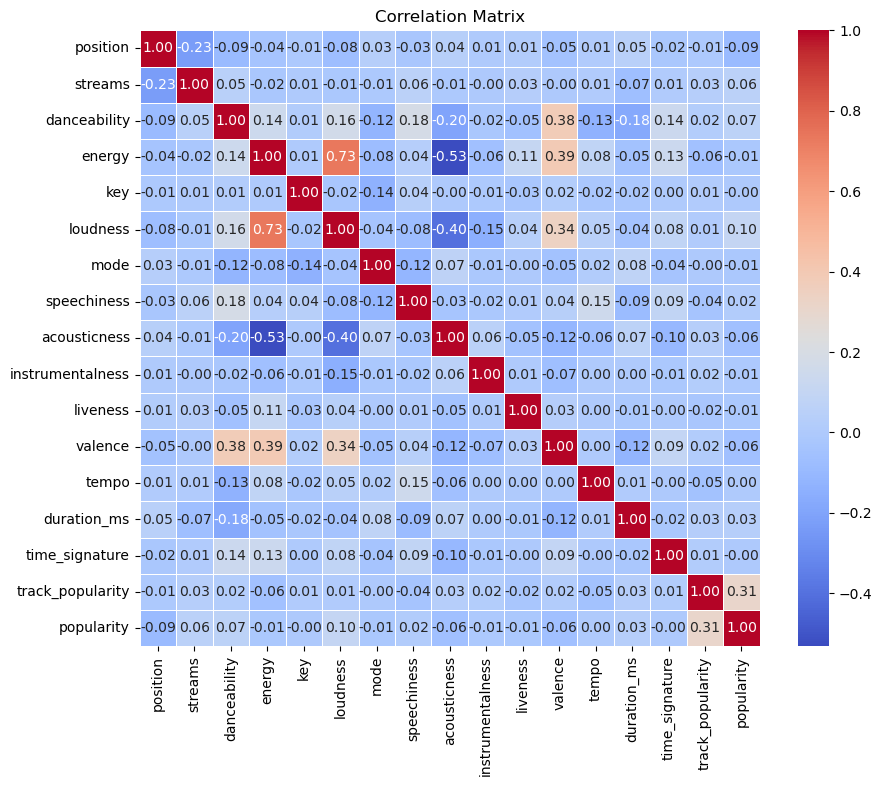

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns from the DataFrame
numeric_columns = df_to_analyse.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the corrplot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Correlation Table NL

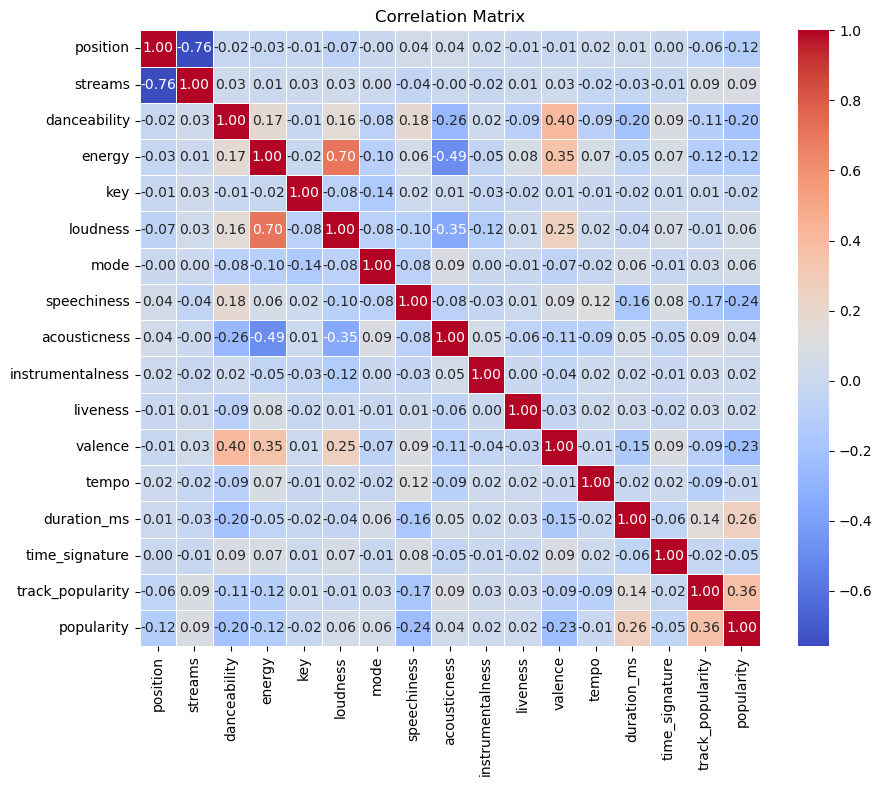

In [18]:
# Select only numeric columns from the NL DataFrame
numeric_columns = df_NL.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the corrplot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Correlation Table Spain

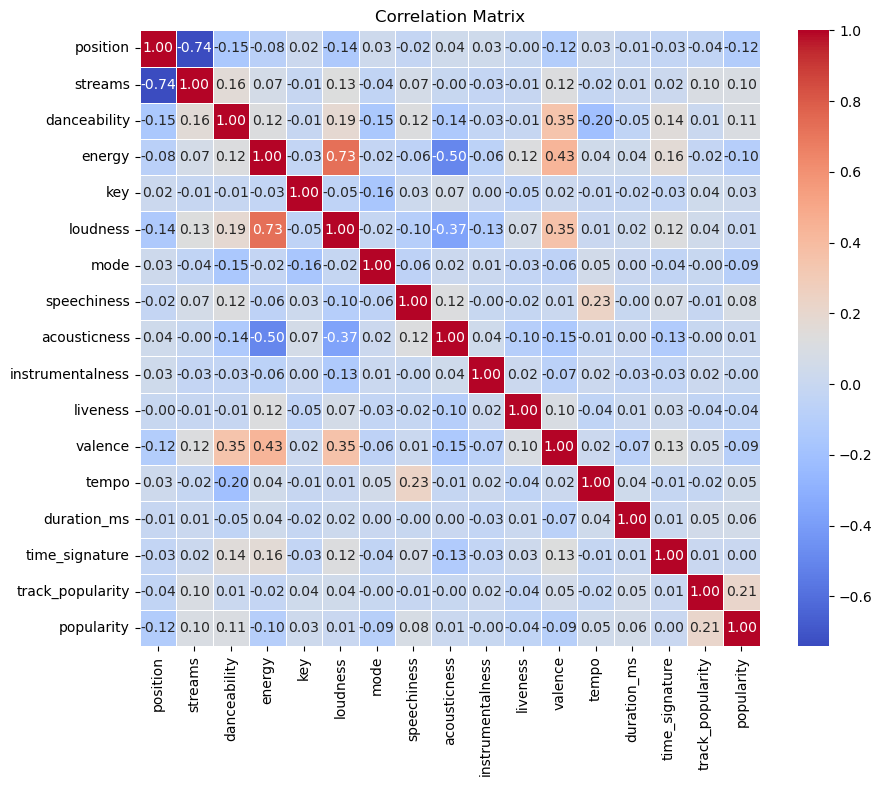

In [20]:
# Select only numeric columns from the NL DataFrame
numeric_columns = df_ES.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the corrplot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Correlation Table UK

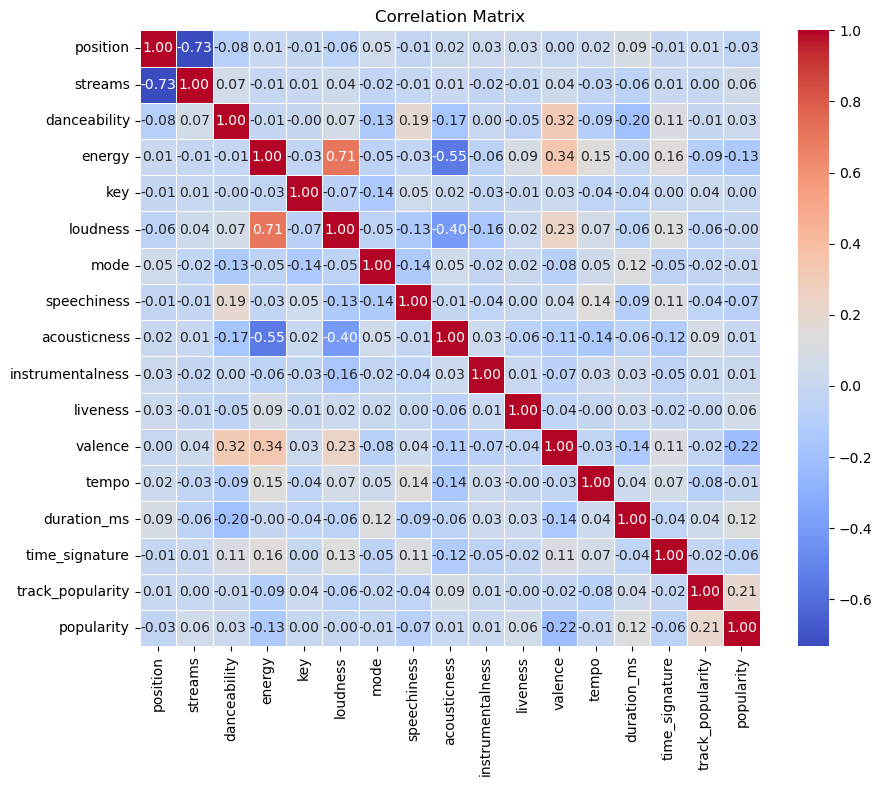

In [21]:
# Select only numeric columns from the NL DataFrame
numeric_columns = df_UK.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create the corrplot using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Ideas for the next steps

- Break down the timeline into 12 and 6-month periods:

  
1. 01-01-2017 - 31-12-2017
3. 01-01-2018 - 31-12-2018
5. 01-01-2019 - 31-12-2019
7. 01-01-2020 - 20.06-2020
* ___20th of June is the last available date___

- Use country clusters for a global comparison

#### Cluster 1: Anglosphere
- Australia
- Canada
- New Zealand
- United States
- United Kingdom

#### Cluster 2: Western Europe
- Germany
- France
- Belgium
- Netherlands
- Austria
- Switzerland
- Sweden
- Denmark
- Norway
- Finland
- Ireland
- Iceland

#### Cluster 3: Central and Eastern Europe
- Czech Republic
- Bulgaria
- Poland
- Slovakia
- Lithuania
- Estonia
- Greece
- Turkey

#### Cluster 4: Latin America and Iberian Peninsula
- Argentina
- Bolivia
- Brazil
- Chile
- Colombia
- Costa Rica
- Dominican Republic
- Ecuador
- Guatemala
- Honduras
- Mexico
- Panama
- Paraguay
- Uruguay
- El Salvador
- Nicaragua
- Spain (added due to language and cultural ties)
- Portugal(linked with Brazil)

#### Cluster 5: Asia-Pacific

- Japan
- Hong Kong
- Taiwan
- Singapore
- Indonesia
- Malaysia
- Philippines
